# 山河事件簿分析工具
riverlog_for_gis.py 需要在 codes 目錄下

文件請參閱:

https://docs.google.com/document/d/1iM_-YdZ8LFFbPkcL-4Irp9Z0laTXgUL2MzfwE4SWtFQ/edit#heading=h.lumlll4mf62a

所有 API 下載範例程式法，下載成 CSV
```
        api_to_csv("rain-dailySum",[2020])
        api_to_csv("rain-10minSum",["2020-09-01"])
        api_to_csv("rain-station",None)
        api_to_csv("rain-rainData",["2020-09-01","23","24","121","122"])
        api_to_csv("waterLevel-station",None)
        api_to_csv("waterLevel-waterLevelData",["2020-09-01","23","24","121","122"])
        api_to_csv("waterLevelDrain-station",None)
        api_to_csv("waterLevelDrain-waterLevelDrainData",["2019-12-03","23","24","120","122"])
        api_to_csv("waterLevelAgri-station",None)
        api_to_csv("waterLevelAgri-waterLevelAgriData",["2019-12-03","23","24","120","122"])
        api_to_csv("sewer-station",None)
        api_to_csv("sewer-sewerData",["2019-12-02","24","25","121","122"])
        api_to_csv("tide-station",None)
        api_to_csv("tide-tideData",["2020-09-01","23","24","121","122"])
        api_to_csv("pump-station",None)
        api_to_csv("pump-pumpData",["2019-12-03","25","26","121","122"])
        api_to_csv("reservoir-info",None)
        api_to_csv("reservoir-reservoirData",["2020-09-01"])
        api_to_csv("flood-station",None)
        api_to_csv("flood-floodData",["2020-09-01"])
        api_to_csv("alert-alertData",["2020-09-01"])
        api_to_csv("alert-alertStatistic",[2020])
        api_to_csv("alert-typhoonData",["2020-09-01"])
        api_to_csv("elev-gridData",["7","23","24","120","121"])
        api_to_csv("statistic-waterUseAgriculture",None)
        api_to_csv("statistic-waterUseCultivation",None)
        api_to_csv("statistic-waterUseLivestock",None)
        api_to_csv("statistic-waterUseLiving",None)
        api_to_csv("statistic-waterUseIndustry",None)
        api_to_csv("statistic-waterUseOverview",None)
        api_to_csv("statistic-monthWaterUse",None)
        api_to_csv("statistic-reservoirUse",None)
        api_to_csv("statistic-reservoirSiltation",None)
```

# Init All

In [4]:
from codes.riverlog_for_gis import * 
from datetime import date
import pandas as pd
from pandas.api.types import is_numeric_dtype
from codes.lib import *

gd = {}

########### 多水庫庫容百分比分析 ###########
## Get/Load Data
#需要的時間範圍可以在此設定

def reservoir_load(bag,date_start, date_end, reservoir_list): #[10405,10201,10205]
    df_info = api_to_csv("reservoir-info",None)
    filename=api_to_csv_range(date_start,date_end,"reservoir-reservoirData",None,"ObservationTime")
    dest_name="%s_GMT8.csv" %(filename[:-4])
    df=csv_add_gmt8(filename,"ObservationTime", dest_name )

    #handle info
    df_info=df_info[df_info['Year']==105]
    df_info.drop_duplicates(subset="id")
    df_info["id"] = pd.to_numeric(df_info["id"])

    #merge/filter
    df2=df.merge(df_info, how='left', left_on='ReservoirIdentifier', right_on='id')
    df2=df2.drop_duplicates(subset=["ObservationTime","ReservoirIdentifier"],keep='last')
    df2=df2[df2['ReservoirIdentifier'].isin(reservoir_list)] #,20101,20201

    #Calculate, Pivot
    df2["ObservationTimeGMT8"] = pd.to_datetime(df2['ObservationTimeGMT8'])
    df2['percent']=df2['EffectiveWaterStorageCapacity']/df2['EffectiveCapacity']*100
    df2=df2[df2['percent']<=100]
    df3 = df2.pivot(index='ObservationTimeGMT8', columns='ReservoirName', values='percent')
    
    bag['reservoir-info']=df_info
    bag['reservoir-reservoirData']=df2
    bag['reservoir_pivot']=df3

def reservoir_plot(bag,title,diff_level=0):
    #plot
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')
    df = bag['reservoir_pivot']
    while diff_level>0:
        df=df.diff()
        diff_level-=1
    df.plot()
    plt.title(title,fontproperties=myfont) 
    plt.legend(prop=myfont)
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    plt.xlabel('時間',fontproperties=myfont)
    plt.ylabel('百分比',fontproperties=myfont)
    plt.show
    
########### 今日淹水 ###########

#可看今天有哪些測站有淹過水
#需要預先準備的測站縣市資訊，在同目錄的 flood-station_縣市鄉鎮.csv，準備方式請參考文件
def flood_load(bag,date_str,limit=0):
    
    #load 測站縣市補充資料
    df_info_縣市鄉鎮 = pd.read_csv("include/flood-station_縣市鄉鎮.csv")

    #get data, process
    df_info=api_to_csv("flood-station",None)
    df_info=df_info.merge(df_info_縣市鄉鎮, how='left', left_on='_id', right_on='_id')
    df_info

    #date_str = date.today() # 2021-06-07
    print("Today is %s" %(date_str))
    df = api_to_csv("flood-floodData",[date_str])

    df["timeGMT8"] = df['time'].apply(date_to_gmt8)
    df["timeGMT8"] = pd.to_datetime(df['timeGMT8'])

    df=df.merge(df_info_縣市鄉鎮, how='left', left_on='stationID', right_on='_id')
    df=df.drop_duplicates(subset=["time","stationName"],keep='last')   
    df['stationName_city']=df['COUNTYNAME']  + '|' + df['TOWNNAME']  + '|' +  df['stationName']

    #filter, sort
    df=df[df['value']>=limit] #可改淹水高度, 有很多淹水資料時，改高一點比較不會太多
    df.sort_values(by=['timeGMT8'])
    
    bag['flood-station_縣市鄉鎮']=df_info_縣市鄉鎮
    bag['flood-station']=df_info
    bag['flood-floodData']=df

def flood_plot(bag,date_str):
    %matplotlib notebook

    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    df = bag['flood-floodData']
    
    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')
    df2 = df.pivot(index='timeGMT8', columns='stationName_city', values='value')
    df2.plot(style='.-')
    title = "%s 淹水感測器淹水值" %(date_str)
    plt.title(title,fontproperties=myfont) 
    plt.legend(prop=myfont)
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    plt.xlabel('時間',fontproperties=myfont)
    plt.ylabel('公分',fontproperties=myfont)
    fig = plt.gcf()
    fig.set_size_inches(8.5, 4.5)
    plt.show

    #淹水測站列表
def flood_list(bag):
    df = bag['flood-floodData']
    ary = df['stationName_city'].unique()
    for name in ary:
        print(name)
        
########### 雨量站相關 ###########

#列出新竹市測站
def rain_station_view():
    df_info = api_to_csv("rain-station",None)
    filter_city = df_info['city']=='新竹縣'
    df_info = df_info[filter_city]

    return df_info


def rain_load(bag, date_str,limit=0,reload=False):
    df_info = api_to_csv("rain-station",None)
    #date_str = date.today() # 2021-06-07
    print("Today is %s" %(date_str))
    df=api_to_csv("rain-rainData",[date_str,"20","26","120","122"],reload)

    df["timeGMT8"] = df['time'].apply(date_to_gmt8)
    df["timeGMT8"] = pd.to_datetime(df['timeGMT8'])

    df=df.merge(df_info, how='left', left_on='stationID', right_on='stationID')
    df=df.drop_duplicates(subset=["timeGMT8","stationID"],keep='last')   
    df['stationName']=df['city']  + '|' + df['town']  + '|' +  df['name'] + '|' + df['stationID']

    #filter, sort
    df=df[df['now']>=limit] #可改雨量值, 有很多淹水資料時，改高一點比較不會太多
    #view_cnt=len(df.index)
    #if view_cnt>=10:
    #    view_count=10
    df=df.sort_values(by=['timeGMT8','stationID'])
    
    bag['rain-station']=df_info
    bag['rain-rainData']=df
    
 
    
#今日雨量 pivot    
def rain_plot(bag,date_str, user_df=None):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    if user_df is None:
        df = bag['rain-rainData']
    else:
        df = user_df
    
    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')
    df2 = df.pivot(index='timeGMT8', columns='stationName', values='now')
    df2.plot(style='.-')
    title = "%s 雨量站值" %(date_str)
    plt.title(title,fontproperties=myfont) 
    plt.legend(prop=myfont)
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    plt.xlabel('時間',fontproperties=myfont)
    plt.ylabel('mm',fontproperties=myfont)
    fig = plt.gcf()
    fig.set_size_inches(8.5, 4.5)
    plt.show 
    
def rain_hourdiff(bag, time_set,station_city):
    #時雨量
    df_info = gd['rain-station']
    df = gd['rain-rainData']

    #df_info.head()
    f1=df_info['city'].isin(station_city)
    #df_info[f1].values.tolist()
    #df_info[f1]['city'].unique()
    stations = df_info[f1]['stationID'].tolist()
    #print(stations)

    #df.head()
    #time_set=['2021-06-10 15:00:00','2021-06-10 16:00:00']
    f_time=df['timeGMT8'].isin(time_set)
    f_station=df['stationID'].isin(stations)
    df_f = df[f_station & f_time]
    #df[f_station]
    #df['city'].unique()

    df_pivot = df_f.pivot(index='stationName', columns='timeGMT8', values='now')
    df_pivot['rain_1hour']=df_pivot[time_set[1]]-df_pivot[time_set[0]] 
    bag['rain-hourdiff']=df_pivot

def to_slot_10min(t_src):
    #t_now = datetime.now()
    #t_added = timedelta(minutes = 10)
    #t_slot= t_src - t_added
    slot_min=int(int(t_src.minute/10)*10)
    date_str="%i-%i-%i %i:%02i:00" %(t_src.year,t_src.month,t_src.day,t_src.hour,slot_min)
    return date_str

def get_2slot(t_src,hour):
    #print("t_src=%s" %(t_src))
    date_str = to_slot_10min(t_src)

    date_obj = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    date_obj2 = date_obj + timedelta(hours = hour)
    date_str2 = date_obj2.strftime("%Y-%m-%d %H:%M:%S")
    
    return [date_str,date_str2]

def rain_alarm_hour(bag,station_city,limit):
    rain_load(gd, date.today(),True)

    #time_set=['2021-06-10 15:00:00','2021-06-10 16:00:00']
    time_now = datetime.now()
    time_set = get_2slot(time_now-timedelta(minutes = 100),1)
    #print(time_set)
    #station_city=['新竹縣','新竹市']
    rain_hourdiff(gd,time_set,station_city)
    df_pivot = gd['rain-hourdiff']

    df_pivot=df_pivot[df_pivot['rain_1hour']>limit]
    df_pivot=df_pivot.sort_values(by=['rain_1hour'],ascending=False)
    
    print("-----\nMonitor time: %s : %s 雨量站時雨量 > %i mm -----\n" %(time_now.strftime("%Y-%m-%d %H:%M:%S"), station_city,limit))
    print(df_pivot) 
    
def rain_day_max(bag,date_str,station_city):
    rain_load(bag, date_str,True)
    #station_city=['新竹縣','新竹市']

    df_info = gd['rain-station']
    df = gd['rain-rainData']

    #df_info.head()
    f1=df_info['city'].isin(station_city)
    #df_info[f1].values.tolist()
    #df_info[f1]['city'].unique()
    stations = df_info[f1]['stationID'].tolist()  
    
    #f_time=df['timeGMT8'].isin(time_set)
    f_station=df['stationID'].isin(stations)
    df_f = df[f_station]
    
    
    df_agg=df_f.groupby('stationName').agg({'now': ['max']})  
    bag['rain_day_max']=df_agg

def rain_load_range(bag,date_start, date_end, limit=0,reload=False): 
    df_info = api_to_csv("rain-station",None)
    #date_str = date.today() # 2021-06-07
    #print("Today is %s" %(date_str))
    filename=api_to_csv_range(date_start,date_end,"rain-rainData",["20","26","120","122"],"time")
    dest_name="%s_GMT8.csv" %(filename[:-4])
    df=csv_add_gmt8(filename,"time", dest_name )
    
    #df=api_to_csv_range("rain-rainData",[date_str,"20","26","120","122"],reload)

    if 1:
        #df["timeGMT8"] = df['time'].apply(date_to_gmt8)
        df["timeGMT8"] = pd.to_datetime(df['timeGMT8'])

        df=df.merge(df_info, how='left', left_on='stationID', right_on='stationID')
        df=df.drop_duplicates(subset=["timeGMT8","stationID"],keep='last')   
        df['stationName']=df['city']  + '|' + df['town']  + '|' +  df['name'] + '|' + df['stationID']

        #filter, sort
        df=df[df['now']>=limit] #可改雨量值, 有很多淹水資料時，改高一點比較不會太多
        df=df.sort_values(by=['timeGMT8','stationID'])

    bag['rain-station']=df_info
    bag['rain-rainData']=df  
    
########### 觀察寶山第二水庫與雨量站的變化 ###########
"""
1.它是離槽水庫，所以要去看它的引水點，頭前溪支流上坪溪的上坪堰的集水區範圍的雨量站：雪壩、白蘭及太閣南三站，掌握這個就可了解趨勢。

2.建議去看寶山第二、永和山、明德、鯉魚潭水庫的水庫入流歷線，會發現這幾個水庫在水文統計數據就可看出，在每年5月間蓄水量都是拐點，之後的梅雨及颱風就會將水位蓄升

畫多張子圖，水庫庫容，多個雨量站
C0D550	雪霸
C1D410	白蘭
01D100	太閣南

地理上的集水區
C0D580 寶山
"""
def rain_reservoir_multi(date_range,station_list,reservoir_list):
    #多雨量站資料
    #date_range=['2021-05-26','2021-06-12']
    if 1:
        #rain_load(gd, date_str,limit=0,reload=True)
        rain_load_range(gd,date_range[0],date_range[1],0,True)
        #gd['rain-rainData']
        df_info = gd['rain-station']
        df1= gd['rain-rainData']

        #station_list=['C0D550','C1D410','01D100','C0D580']

        f1=df1['stationID'].isin(station_list)
        df1 = df1[f1]
        #print(df1.columns)

        #rain_plot(gd,date_str, df[f1])

    #寶二水庫
    if 1:
        reservoir_load(gd,date_range[0],date_range[1],reservoir_list)
        #reservoir_plot(gd)
        df2=gd['reservoir-reservoirData']
        #reservoir_list = [10405]
        #print(df2.columns)

    if 1:
        %matplotlib notebook
        import matplotlib.pyplot as plt
        from matplotlib.font_manager import FontProperties

        myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')

        count_all = len(station_list)+len(reservoir_list)
        fig, axs = plt.subplots(count_all)
        title = "%s-%s 雨量站與水庫庫容" %(date_range[0],date_range[1])
        fig.suptitle(title,fontproperties=myfont)
        ax_cur=0

        for i in range(len(station_list)):
            #label = station_list[i]
            label = get_value_by_index(df1,"stationID=%s" %(station_list[i]), 'stationName')
            axs[ax_cur].set_ylabel(label,fontproperties=myfont) #,loc="top"
            #axs[i].plot(x, y)
            f1=df1['stationID']==station_list[i]
            df1[f1].plot(x='timeGMT8',y='now',ax=axs[ax_cur],label=label,color='red',legend=None) #no need to specify for first axi
            ax_cur+=1
            #print("subplot %i processed" %(ax_cur))
        for j in range(len(reservoir_list)):
            label = reservoir_list[j]
            #label = get_value_by_index(df2,"ReservoirIdentifier=%i" %(reservoir_list[j]), 'ReservoirName')
            label = get_value_by_index(df2,"id=%i" %(reservoir_list[j]), 'ReservoirName')
            axs[ax_cur].set_ylabel(label,fontproperties=myfont) #,loc="top"
            #axs[j].plot(x, y)
            f2=df2['ReservoirIdentifier']==reservoir_list[j]
            #names = df2[f2]['ReservoirName'].tolist()
            df2[f2].plot(x='ObservationTimeGMT8',y='percent',ax=axs[ax_cur],label=label,color='blue',legend=None) #no need to specify for first axi
            ax_cur+=1
            #print("subplot %i processed" %(ax_cur))

        #plt.title(title,fontproperties=myfont) 
        plt.xticks(fontname = 'SimSun',size=10)
        plt.yticks(fontname = 'SimSun',size=10)
        fig = plt.gcf()
        fig.set_size_inches(12.0, 4*count_all)
        plt.show

########### 水位站 ###########
#查水位站
#常用站點 '河川水位測站-內灣-1300H013','河川水位測站-經國橋-1300H017' , '河川水位測站-上坪-1300H014'
def waterLevel_view():
    df_info = api_to_csv("waterLevel-station",None) #'BasinIdentifier',ObservatoryName
    filter_river = df_info['RiverName']=='上坪溪'
    #filter_name = df_info['BasinIdentifier']=='1300H017'

    # ID 查名稱
    #value=get_value_by_index(df_info,"BasinIdentifier=1140H037", 'ObservatoryName')
    value=get_value_by_index(df_info,"ObservatoryName=河川水位測站-內灣-1300H013", 'BasinIdentifier')
    print(value)

    return df_info[filter_river]

#準備今天的資料
def waterLevel_load(bag,date_str,reload=False):
    df_info = api_to_csv("waterLevel-station",None) #'BasinIdentifier',ObservatoryName

    #date_str=date.today() #2021-06-08
    #date_str='2021-06-08'

    df=api_to_csv("waterLevel-waterLevelData",[date_str,"23","25","120","123"],reload) #'RecordTime', 'StationIdentifier', 'WaterLevel'


    df["RecordTimeGMT8"] = df['RecordTime'].apply(date_to_gmt8)
    df["RecordTimeGMT8"] = pd.to_datetime(df['RecordTimeGMT8'])

    df=df.merge(df_info, how='left', left_on='StationIdentifier', right_on='BasinIdentifier')
    df=df.drop_duplicates(subset=["RecordTimeGMT8","StationIdentifier"],keep='last')   
    df['stationName']=df['StationIdentifier']  + '|' + df['ObservatoryName'] 

    #filter, sort
    df=df[df['WaterLevel']>0] #可改水位值, 有很多淹水資料時，改高一點比較不會太多

    df=df.sort_values(by=['RecordTimeGMT8','StationIdentifier'])
    
    bag['waterLevel-station']=df_info
    bag['waterLevel-waterLevelData']=df
    
#畫單站圖表
def waterLevel_plotA(bag, StationId,diff_level=0,filename=None):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    df = bag['waterLevel-waterLevelData']
    filter_river = df['StationIdentifier']==StationId
    #filter_river = df['RiverName'].str.contains('頭前溪', na=False)
    
    df = df[filter_river]
    if len(df.index)==0:
        print("df have no data")


    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')
    df2 = df.pivot(index='RecordTimeGMT8', columns='stationName', values='WaterLevel')
    title = "%s 水位值, S0_V1_A2=%i" %(date_str,diff_level)
    while diff_level>0:
        df2=df2.diff()
        diff_level-=1
    if not filename is None:
        plt.switch_backend('Agg')
    else:
        plt.switch_backend('nbAgg')
    df2.plot(style='.-')
    plt.title(title,fontproperties=myfont) 
    plt.legend(prop=myfont)
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    plt.xlabel('時間',fontproperties=myfont)
    plt.ylabel('米',fontproperties=myfont)
    fig = plt.gcf()
    fig.set_size_inches(8.0, 4.5)
    if not filename is None:
        plt.savefig(filename)
    else:
        plt.show() 
    return df2
    
#兩個水位站畫在一張圖上
def waterLevel_plotB(bag, river_pair):
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    df_info = bag['waterLevel-station']
    df = bag['waterLevel-waterLevelData']
    
    #river_pair=['河川水位測站-內灣-1300H013','河川水位測站-經國橋-1300H017' ] #河川水位測站-上坪-1300H014
    
    river_pair.append(get_value_by_index(df_info,"ObservatoryName="+river_pair[0], 'BasinIdentifier'))
    river_pair.append(get_value_by_index(df_info,"ObservatoryName="+river_pair[1], 'BasinIdentifier'))

    river1 = df['BasinIdentifier']==river_pair[2+0]
    river2 = df['BasinIdentifier']==river_pair[2+1]
    river_both = river1 | river2

    df = df[river_both] 

    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.set_ylabel(river_pair[0],fontproperties=myfont) #,loc="top"

    df[river1].plot(x='RecordTimeGMT8',y='WaterLevel',ax=ax1,label=river_pair[0],color='red',legend=None) #no need to specify for first axis

    ax2.set_ylabel(river_pair[1],fontproperties=myfont)
    df[river2].plot(x='RecordTimeGMT8',y='WaterLevel',ax=ax2,label=river_pair[1],color='blue',legend=None)

    title = "%s 水位值, 紅左藍右" %(date_str)
    plt.title(title,fontproperties=myfont) 
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    fig = plt.gcf()
    fig.set_size_inches(7.0, 5)
    plt.show
    
########### 單雨量站+單水位站 混合圖 ###########
#想觀察雨量站跟水位站的關係
def rain_load1(bag, date_str,reload=False):
    df_info = api_to_csv("rain-station",None)
    #date_str = date.today() # 2021-06-07
    print("Today is %s" %(date_str))
    df=api_to_csv("rain-rainData",[date_str,"23","25","121","122"],reload)

    df["timeGMT8"] = df['time'].apply(date_to_gmt8)
    df["timeGMT8"] = pd.to_datetime(df['timeGMT8'])

    df=df.merge(df_info, how='left', left_on='stationID', right_on='stationID')
    df=df.drop_duplicates(subset=["timeGMT8","stationID"],keep='last')   
    df['stationName']=df['city']  + '|' + df['town']  + '|' +  df['name'] + '|' + df['stationID']

    #filter, sort
    #df=df[df['now']>10] #可改雨量值, 有很多淹水資料時，改高一點比較不會太多
    df=df.sort_values(by=['timeGMT8','stationID'])
    
    bag['rain-station']=df_info
    bag['rain-rainData']=df
    
def rain_waterLevel_plot(bag,pair):

    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    #pair=['內灣國小',河川水位測站-內灣-1300H013']

    myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    #ax2 先做就正常 [FIXME]
    ax2.set_ylabel(pair[1],fontproperties=myfont)
    bag['df2'].plot(x='RecordTimeGMT8',y='WaterLevel',ax=ax2,label=pair[1],color='blue',legend=None)
    
    ax1.set_ylabel(pair[2+0],fontproperties=myfont) #,loc="top"
    bag['df1'].plot(x='timeGMT8',y='now',ax=ax1,label=pair[2+0],color='red',legend=None) #no need to specify for first axis




    title = "%s 雨量/水位值, 紅左藍右" %(date_str)
    plt.title(title,fontproperties=myfont) 
    plt.xticks(fontname = 'SimSun',size=8)
    plt.yticks(fontname = 'SimSun',size=8)
    fig = plt.gcf()
    fig.set_size_inches(7.0, 5)
    plt.show  

########### 時間差變化 ###########
# 今日水位差

def mydiff(series):
    values = series.tolist()
    return max(values)-min(values)


def waterLevel_diff(bag,date_str,filter_def=None): #BasinIdentifier,RiverName,stationName
    waterLevel_load(gd,date_str,True)
    df_waterLevel_info=gd['waterLevel-station']
    df_waterLevel = gd['waterLevel-waterLevelData']
    #print(df_waterLevel.columns)

    if filter_def:
        cols=filter_def.split("=")
        #f1=df_waterLevel[cols[0]]==cols[1]
        f1=df_waterLevel[cols[0]].str.contains(cols[1], na=False) #RiverName 欄位值似乎有問題
        
        df=df_waterLevel[f1]
    else:
        df=df_waterLevel

    df_agg=df.groupby('stationName').agg({'WaterLevel': ['max',mydiff]})    
    return df_agg


# 基本使用範例

In [20]:
########### 多水庫庫容百分比分析 ###########
date_str='2021-06-09' #date.today() #'2021-06-09'
head_count=10

station_city=['新竹縣','新竹市']

"""
station_city=['南投縣', '基隆市', '新北市', '臺北市', '新竹縣', '臺中市', '澎湖縣', '嘉義縣', '嘉義市',
       '臺南市', '高雄市', '屏東縣', '宜蘭縣', '花蓮縣', '臺東縣', '金門縣', '桃園市', '彰化縣',
       '連江縣', '雲林縣', '苗栗縣', '新竹市']
"""
if 0:
    reservoir_load(gd,"2021-05-27","2021-06-24",[10405,10201,10205]) #[10405,10201,10205]
    reservoir_plot(gd,"多水庫時間內庫容比例每小時變動加速度",0)

########### 今日淹水 ###########
if 0:
    flood_load(gd,date_str,10)
    flood_plot(gd,date_str)
    #flood_list(gd)
    
########### 雨量站相關 ###########
#rain_station_view()

if 0: #某日雨量圖
    rain_load(gd, date_str,100,True)
    rain_plot(gd,date_str)

if 0: #時雨量最大值 FIXME
    #time_set=['2021-06-10 15:00:00','2021-06-10 16:00:00']
    time_set = get_2slot(datetime.now()-timedelta(minutes = 80),1)
    print(time_set)
    
    
    rain_hourdiff(gd,time_set,station_city)
    df_pivot = gd['rain-hourdiff']

    df_pivot=df_pivot[df_pivot['rain_1hour']>0]
    df_pivot=df_pivot.sort_values(by=['rain_1hour'],ascending=False)
    print(df_pivot)
    
if 0:#今日雨量
    rain_day_max(gd,date.today(),station_city)  
    df_agg=gd['rain_day_max']
    print(df_agg.sort_values([('now', 'max')], ascending=False).head(head_count))

########### 觀察寶山第二水庫與雨量站的變化 ###########
if 0:
    rain_reservoir_multi(['2021-06-15','2021-06-22'],['C0D550','C1D410','01D100','C0D580'],[10405]) 
########### Monitor ###########
if 0: #FIXME
    #Alarm 時雨量監控
    while True:
        #print(datetime.now())
        rain_alarm_hour(gd,station_city,1)
        time.sleep(600)
        
########### 水位站 ###########
if 1: #某天，(兩)水位站水位圖
    import time
    gd={}
    #waterLevel_view()

    date_pair=['2021-05-27','2021-06-10']
    station_list=['1300H014','1300H016','1300H017','1300H020'] # '1300H021'（舊港橋，海邊），無值'1300H022','1300H023','1300H024'

    
    
    results=[]
    for st_id in station_list:
        print("st_id=%s" %(st_id))
        date_str=date_pair[0]
        
        while(date_str<=date_pair[1]):

            waterLevel_load(gd,date_str)
            #st_id='1300H017'
            df = waterLevel_plotA(gd,st_id ,2,'output/waterLevel_fig_%s.png' %(date_str))
            #rint("%s %s max=%.2f" %(st_id,date_str,df['1300H017|經國橋'].max()))
            #results.append([date_str, df['1300H017|經國橋'].max()])
            st_name=df.columns[0]
            results.append([date_str,st_name,df[st_name].max()])
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
            date_obj2 = date_obj + timedelta(hours = 24)
            date_str = date_obj2.strftime("%Y-%m-%d")
    df2 = pd.DataFrame(results,columns =['date', 'name','a'])



if 0:
    date_str='2021-06-09'
    st_id='1300H017'
    waterLevel_load(gd,date_str)
    df = waterLevel_plotA(gd,st_id)

if 0:
    print("result=%s" %(result))
    river_pair=['河川水位測站-上坪-1300H014','河川水位測站-經國橋-1300H017'] 
    waterLevel_plotB(gd, river_pair)
    
########### 單雨量站+單水位站 混合圖 ###########
if 0: 
    #date_str='2021-06-09'
    pair=['81D650','河川水位測站-內灣-1300H013'] #雨量站： 內灣國小 
    #rain
    rain_load1(gd,date_str,True)
    df_rain = gd['rain-rainData']
    df_rain_info = gd['rain-station']
    gd['df1']=df_rain[df_rain['stationID']==pair[0]]

    #waterLevel
    waterLevel_load(gd,date_str,False)
    df_waterLevel_info=gd['waterLevel-station']
    df_waterLevel = gd['waterLevel-waterLevelData']

    pair.append(get_value_by_index(df_rain,"stationID="+pair[0], 'stationName'))
    pair.append(get_value_by_index(df_waterLevel_info,"ObservatoryName="+pair[1], 'BasinIdentifier'))

    filter1 = df_waterLevel['BasinIdentifier']==pair[2+1]
    gd['df2']=df_waterLevel[filter1]

    rain_waterLevel_plot(gd,pair)
    #gd['df1']
    #df_rain_info  
########### 時間差變化 ###########
if 0: #河流水位測站某日水位最大差
    df_agg = waterLevel_diff(gd,date_str,"RiverName=頭前溪") #"BasinIdentifier=1300H013"
    df_agg= df_agg.sort_values([('WaterLevel', 'mydiff')], ascending=False)
    print(df_agg)
########### 警示 ###########
#geocode 可參考郵遞區號.csv
if 0:
    df=api_to_csv("alert-alertData",[date_str])
    print(df)

if 0: #今日雨量
    rain_day_max(gd,date_str,station_city)  
    df_agg=gd['rain_day_max']
    print("日期：%s 縣市：%s 最高雨量" %(date_str,station_city)) 
    print(df_agg.sort_values([('now', 'max')], ascending=False).head(head_count))

if 0: #雨量站縣市清單
    df = gd['rain-station']
    print(df['city'].unique())



st_id=1300H014
waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-27.csv saved, shape = (5214, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-28.csv saved, shape = (5106, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-29.csv saved, shape = (5226, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-30.csv saved, shape = (4985, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-31.csv saved, shape = (4740, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-01.csv saved, shape = (5307, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-02.csv saved, shape = (5131, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-03.csv saved, shape = (5065, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-04.csv saved, shape = (5343, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-05.csv saved, shape = (5344, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-06.csv saved, shape = (5330, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-07.csv saved, shape = (5314, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-08.csv saved, shape = (5316, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-09.csv saved, shape = (4950, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-10.csv saved, shape = (4799, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


st_id=1300H016
waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-27.csv saved, shape = (5214, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-28.csv saved, shape = (5106, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-29.csv saved, shape = (5226, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-30.csv saved, shape = (4985, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-31.csv saved, shape = (4740, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-01.csv saved, shape = (5307, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-02.csv saved, shape = (5131, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-03.csv saved, shape = (5065, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-04.csv saved, shape = (5343, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-05.csv saved, shape = (5344, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-06.csv saved, shape = (5330, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-07.csv saved, shape = (5314, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-08.csv saved, shape = (5316, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-09.csv saved, shape = (4950, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-10.csv saved, shape = (4799, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


st_id=1300H017
waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-27.csv saved, shape = (5214, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-28.csv saved, shape = (5106, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-29.csv saved, shape = (5226, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-30.csv saved, shape = (4985, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-31.csv saved, shape = (4740, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-01.csv saved, shape = (5307, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-02.csv saved, shape = (5131, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-03.csv saved, shape = (5065, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-04.csv saved, shape = (5343, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-05.csv saved, shape = (5344, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-06.csv saved, shape = (5330, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-07.csv saved, shape = (5314, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-08.csv saved, shape = (5316, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-09.csv saved, shape = (4950, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-10.csv saved, shape = (4799, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


st_id=1300H020
waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-27.csv saved, shape = (5214, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-28.csv saved, shape = (5106, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-29.csv saved, shape = (5226, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-30.csv saved, shape = (4985, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-05-31.csv saved, shape = (4740, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-01.csv saved, shape = (5307, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-02.csv saved, shape = (5131, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-03.csv saved, shape = (5065, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-04.csv saved, shape = (5343, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-05.csv saved, shape = (5344, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-06.csv saved, shape = (5330, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-07.csv saved, shape = (5314, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-08.csv saved, shape = (5316, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-09.csv saved, shape = (4950, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


waterLevel-station: output/waterLevel-station.csv saved, shape = (5176, 13)
waterLevel-waterLevelData: output/waterLevel-waterLevelData_2021-06-10.csv saved, shape = (4799, 3)


/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wuulong/.local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


# Debug 紀錄

<IPython.core.display.Javascript object>


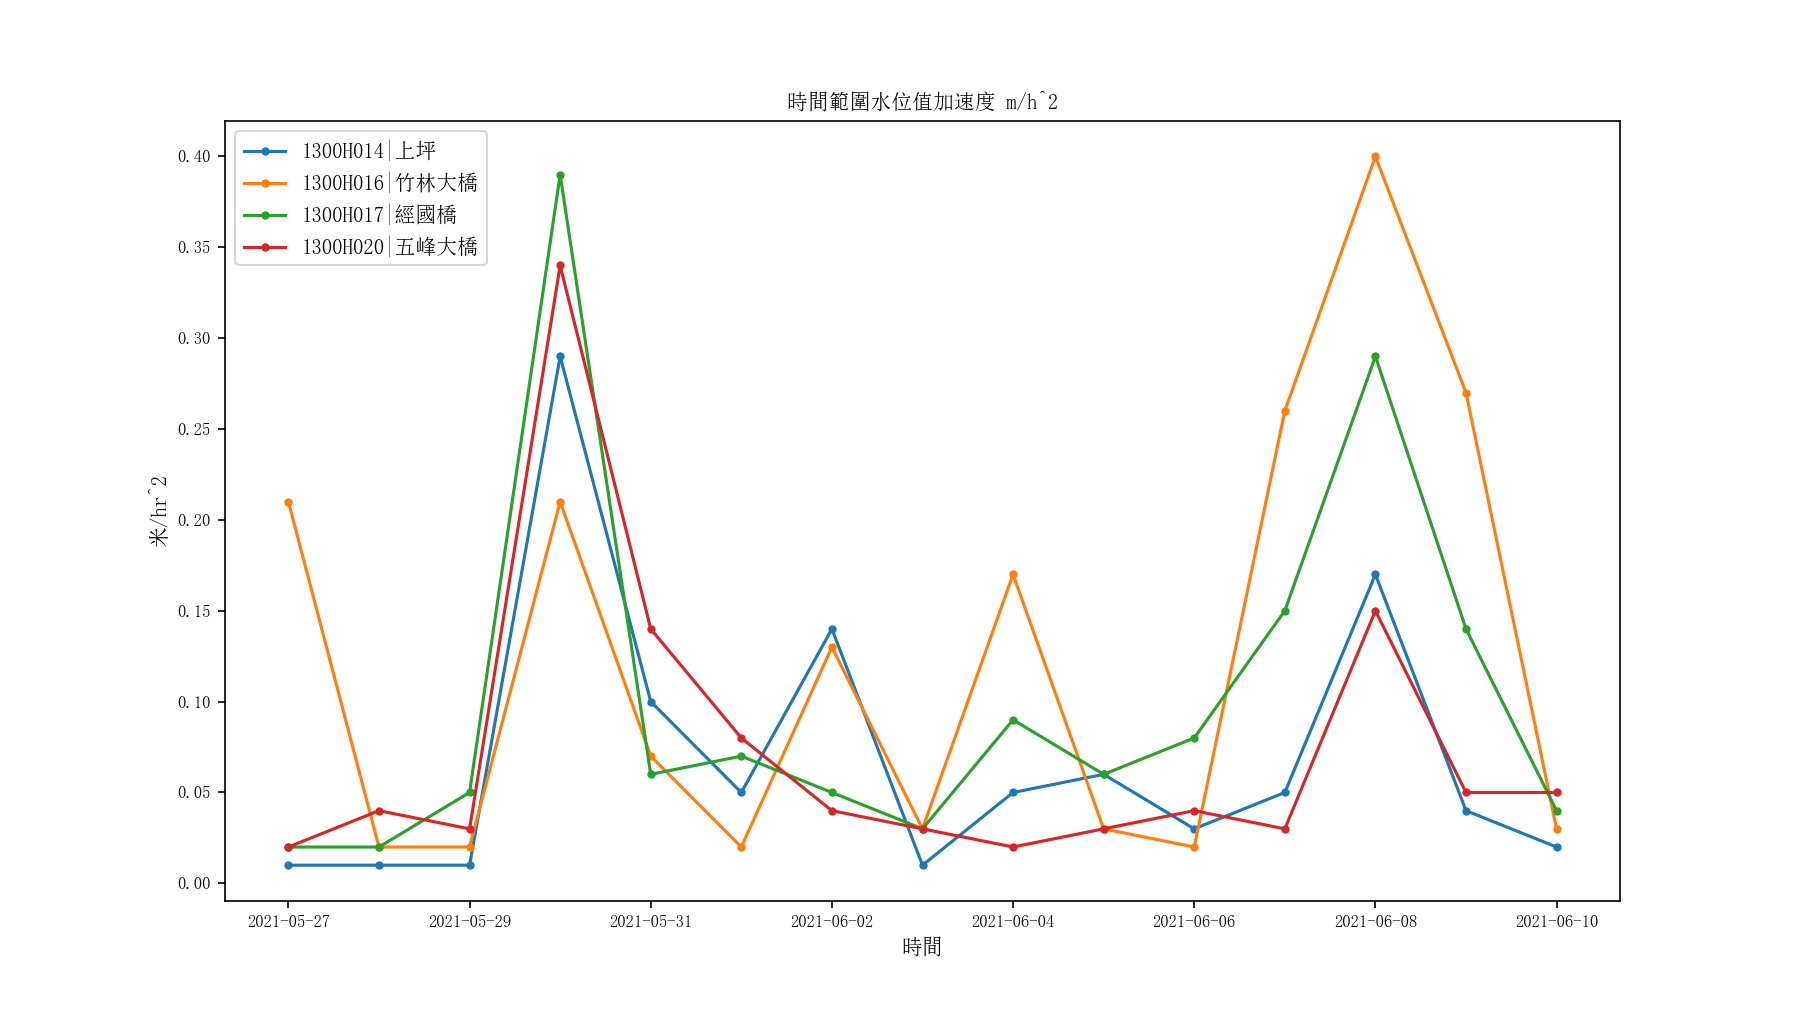

/Volumes/F2020/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


In [21]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.switch_backend('nbAgg')
myfont = FontProperties(fname=r'/Library/Fonts/Microsoft/SimSun.ttf')
title = "時間範圍水位值加速度 m/h^2"
#df2.plot(style='.-')
df3 = df2.pivot(index='date', columns='name', values='a')
df3.plot(style='.-')
plt.title(title,fontproperties=myfont) 
plt.legend(prop=myfont)
plt.xticks(fontname = 'SimSun',size=8)
plt.yticks(fontname = 'SimSun',size=8)
plt.xlabel('時間',fontproperties=myfont)
plt.ylabel('米/hr^2',fontproperties=myfont)
fig = plt.gcf()
fig.set_size_inches(8.0, 4.5)

In [4]:
import numpy as np
import pandas as pd
print("np ver:%s , pd ver: %s" %(np.__version__,pd.__version__))
#Fail version Pair: np ver:1.20.3 , pd ver: 0.25.3 #pandas>=1.0.5
#PASS version pari: np ver:1.20.3 , pd ver: 1.0.5

np ver:1.20.3 , pd ver: 1.0.5


In [3]:
import matplotlib
print (matplotlib.rcParams['backend']) 

nbAgg


In [172]:
import matplotlib.pyplot as plt
plt.switch_backend('nbAgg')